In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

from data_handling import Dataframe, MineDataset

DIR_INPUT = './new_output'

In [2]:
dataframe = Dataframe(dataset_folder='new_output/')
dataframe.load_images()

train, val, test = dataframe.train_test_split()

57
57
57
57
57
57


In [3]:
len(train), len(val), len(test)

(592, 169, 85)

In [4]:
# Albumentations
def get_train_transform():
    return A.Compose(transforms=[
        A.Flip(),
        A.Resize(256, 256),
        A.Normalize(normalization="image"),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose(transforms=[
        A.Resize(256, 256),
        A.Normalize(normalization="image"),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [5]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

/home/kala/Documents/Tues/munich-defense-tech/ObjectDetection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kala/Documents/Tues/munich-defense-tech/ObjectDetection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = MineDataset(train, get_train_transform())
valid_dataset = MineDataset(val, get_valid_transform())
test_dataset = MineDataset(test, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
# train_data = [(images, targets) for images, targets in (iter(train_data_loader))]

In [11]:
# len(train_data)

In [12]:
# train_data[287]

In [13]:
# for idx, (images, targets) in enumerate(train_data):
#     for target in targets:
#         if target['boxes'].shape[0] > 1:
#             print(idx)
#         break

In [14]:
#train_data[5]

# Sample

In [15]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [16]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1, 2, 0).cpu().numpy()

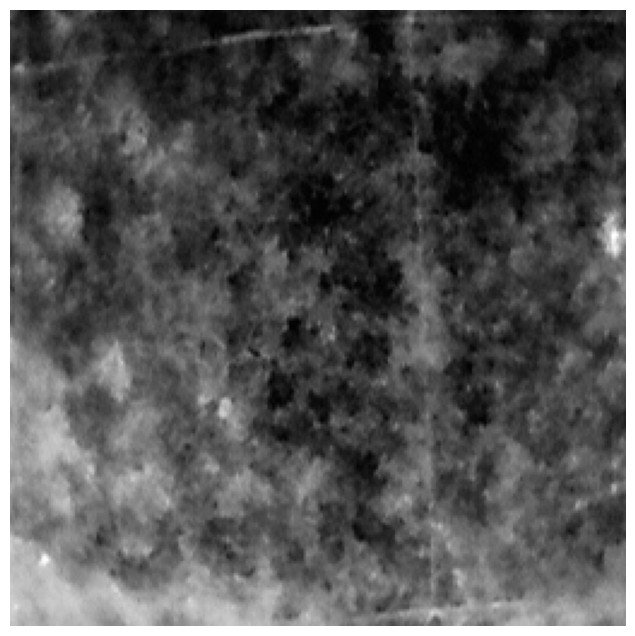

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample, cmap='gray')

# Train

In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

num_epochs = 4

In [19]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.24248011696255417
Iteration #100 loss: 0.1423888465019605
Iteration #150 loss: 0.13439018534212763
Iteration #200 loss: 0.00405461248010397
Iteration #250 loss: 0.2874170232449219
Epoch #0 loss: 0.12756608346211787
Iteration #300 loss: 0.1269133040573447
Iteration #350 loss: 0.20693359443714726
Iteration #400 loss: 0.04552516198547933
Iteration #450 loss: 0.18146922691771383
Iteration #500 loss: 0.04560059872191736
Iteration #550 loss: 0.07174688098672144
Epoch #1 loss: 0.099794867236115
Iteration #600 loss: 0.007556014694273472
Iteration #650 loss: 0.08162414325568842
Iteration #700 loss: 0.10172038773789292
Iteration #750 loss: 0.14439424343475887
Iteration #800 loss: 0.09929021880320331
Iteration #850 loss: 0.06981690662661583
Epoch #2 loss: 0.09307377146829243
Iteration #900 loss: 0.0006945428904145956
Iteration #950 loss: 0.1659348359193753
Iteration #1000 loss: 0.046640889276121235
Iteration #1050 loss: 0.10206635638956656
Iteration #1100 loss: 0.06809992057

# Test

In [20]:
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [21]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [22]:
test_data = [(images, targets) for images, targets in (iter(test_data_loader))]

In [23]:
test_data

[((tensor([[[ 0.5371,  0.4174, -0.0837,  ..., -0.1944, -0.0841, -0.3485],
            [ 0.0686, -0.0058,  0.0236,  ..., -0.3808, -0.1062, -0.2802],
            [-0.0756,  0.1117, -0.3832,  ..., -0.3491, -0.2592, -0.1966],
            ...,
            [-0.9625, -0.9355, -1.0311,  ..., -0.4812, -0.6144, -0.8584],
            [-0.8608, -0.9841, -1.0591,  ..., -0.7535, -1.0192, -1.0671],
            [-0.8841, -1.0953, -1.0364,  ..., -0.9004, -1.1763, -1.1517]]]),),
  ({'boxes': tensor([[ 49.0880,  22.2187, 162.8658, 199.8187]], dtype=torch.float64),
    'area': tensor([106560.]),
    'labels': tensor([1]),
    'image_id': tensor([0]),
    'iscrowd': tensor([0])},)),
 ((tensor([[[-1.7862, -1.7072, -1.7107,  ...,  0.4227,  0.5825,  0.2927],
            [-1.7090, -1.5035, -1.3244,  ...,  0.5667,  0.6685,  0.5947],
            [-1.7687, -1.4105, -1.2489,  ...,  0.5421,  0.6158,  0.5947],
            ...,
            [ 0.1874, -0.2498, -0.2814,  ..., -1.2138, -0.7590, -0.6115],
            [ 0.

In [24]:
images, targets = test_data[0]
#images = list(image.to(device) for image in images)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
cpu_device = torch.device("cpu")
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

out_boxes = outputs[0]['boxes'].data.cpu().numpy().astype(np.int32)
gt_boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

outputs

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [25]:
test_data[33]

((tensor([[[-2.0115, -1.9381, -0.9740,  ..., -0.8865, -1.5409,  0.6947],
           [-2.0148, -1.5788, -0.5686,  ..., -0.9414, -1.6049,  0.3540],
           [-1.4661, -0.7680, -0.7218,  ..., -0.5525, -1.2808,  0.6848],
           ...,
           [-0.9677, -0.8873, -0.9263,  ..., -1.1486, -1.6889, -1.9597],
           [-1.0209, -1.0949, -1.1576,  ..., -1.2311, -2.1750, -2.2156],
           [-1.2754, -1.4748, -1.4074,  ..., -1.2490, -2.1072, -2.2029]]]),),
 ({'boxes': tensor([], size=(0, 4)),
   'area': tensor([0.]),
   'labels': tensor([0]),
   'image_id': tensor([33]),
   'iscrowd': tensor([], dtype=torch.int64)},))

now at 0 of 85
now at 1 of 85
now at 2 of 85
now at 3 of 85
now at 4 of 85
now at 5 of 85
now at 6 of 85
now at 7 of 85
now at 8 of 85
now at 9 of 85
now at 10 of 85
now at 11 of 85
now at 12 of 85
now at 13 of 85
now at 14 of 85
now at 15 of 85
now at 16 of 85
now at 17 of 85
now at 18 of 85
now at 19 of 85
now at 20 of 85
now at 21 of 85
now at 22 of 85
now at 23 of 85
now at 24 of 85
now at 25 of 85
now at 26 of 85
now at 27 of 85
now at 28 of 85
now at 29 of 85


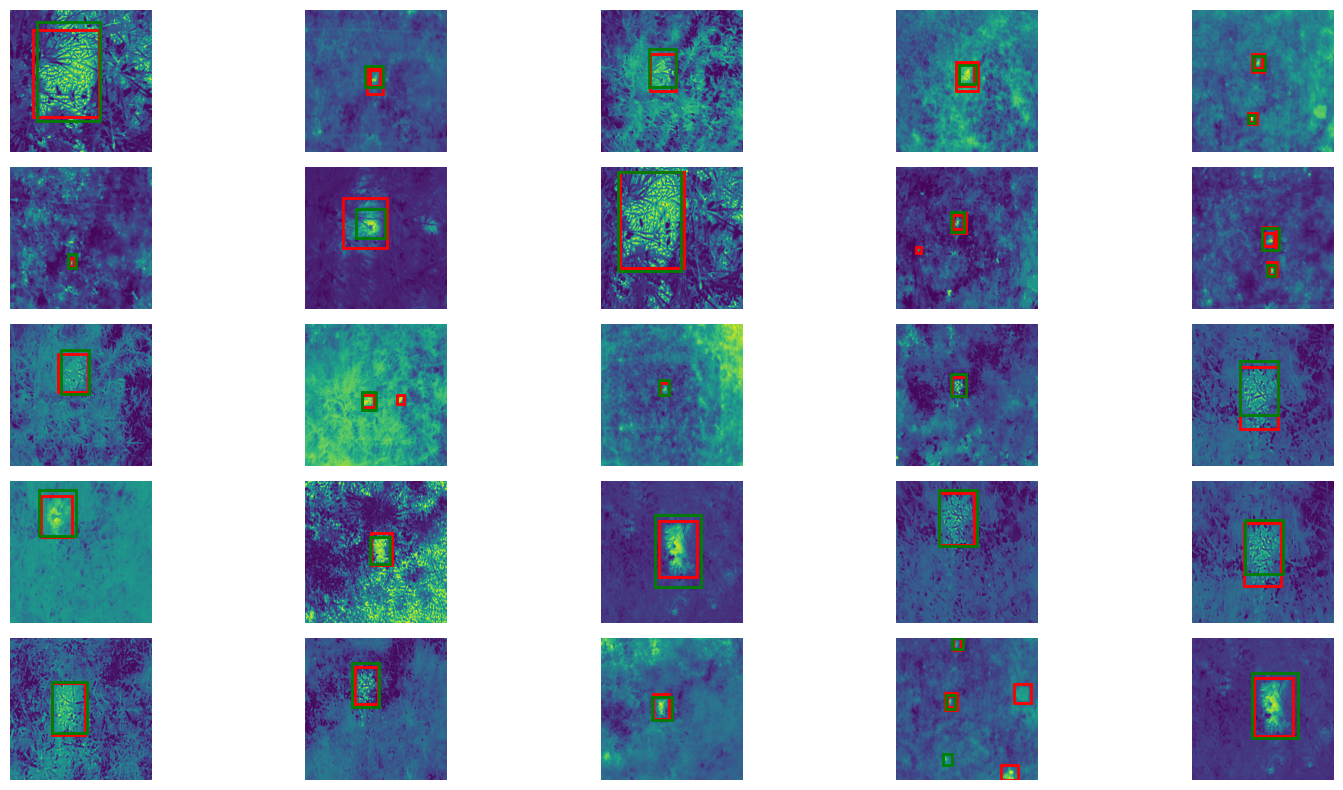

0.03262368334080571

In [27]:
avg_iou = 0
false_positives = 0
false_negatives = 0

threshold = 0.4

fig, ax = plt.subplots(5, 5, figsize=(16, 8))
ax = ax.flatten()

l = 0
model.eval()
for i, test in enumerate(test_data):
    if l == 25:
        break

    print("now at", i, "of", len(test_data))

    images, targets = test
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    model.eval()
    cpu_device = torch.device("cpu")

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

    if len(outputs[0]['boxes']) == 0:
        if len(targets[0]['boxes']) == 0:
            avg_iou += 1
            continue
        else:
            false_negatives += 1
            continue

    if outputs[0]['scores'][0] > threshold and targets[0]['boxes'].shape[0] == 0:
        false_positives += 1
        continue

    if outputs[0]['scores'][0] < threshold and targets[0]['boxes'].shape[0] > 0:
        false_negatives += 1
        continue

    if targets[0]['boxes'].shape[0] == 0:
        avg_iou += 1
        continue

    out_boxes = outputs[0]['boxes'].data.cpu().numpy().astype(np.int32)
    gt_boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

    s1 = images[0].permute(1, 2, 0).cpu().numpy().copy() * 256

    for idx, box in enumerate(out_boxes):
        if outputs[0]['scores'][idx] < threshold:
            continue
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax[l].add_patch(rect)

    for box in gt_boxes:
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             linewidth=2, edgecolor='g', facecolor='none')
        ax[l].add_patch(rect)

    ax[l].set_axis_off()
    ax[l].imshow(s1)

    iou = intersection_over_union(out_boxes[0], gt_boxes[0])
    avg_iou += iou

    l += 1

plt.tight_layout()
plt.show()
avg_iou / (len(test_data) - false_positives - false_negatives)

In [30]:
def get_test_transform():
    return A.Compose(transforms=[
        A.Resize(256, 256),
        A.Normalize(normalization="image"),
        ToTensorV2(p=1.0)
    ],)


In [40]:
test_image = cv2.imread("test_image.JPG", cv2.IMREAD_GRAYSCALE)


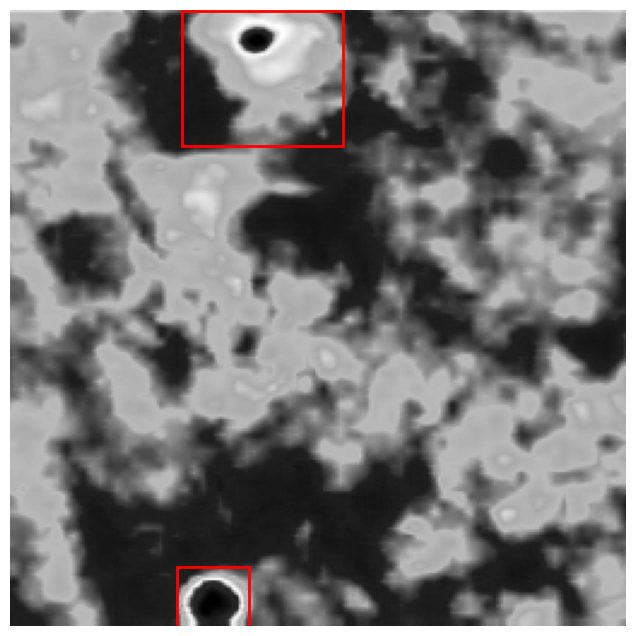

In [41]:
test_image = get_test_transform()(image=np.array(test_image))['image']

test_image = test_image.to(device)

model.eval()
outputs = model([test_image])

outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

out_boxes = outputs[0]['boxes'].data.cpu().numpy().astype(np.int32)

s1 = test_image.permute(1, 2, 0).cpu().numpy().copy() * 256

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for idx, box in enumerate(out_boxes):
    if outputs[0]['scores'][idx] < threshold:
        continue
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                         linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
ax.set_axis_off()
ax.imshow(s1, cmap='gray')
plt.show()

In [22]:
images, targets = next(iter(test_data_loader))

In [23]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [28]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1, 2, 0).cpu().numpy() * 256

In [29]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [33]:
out_boxes = outputs[0]['boxes'].data.cpu().numpy().astype(np.int32)
out_boxes[0]

array([ 79,  48, 159, 180], dtype=int32)

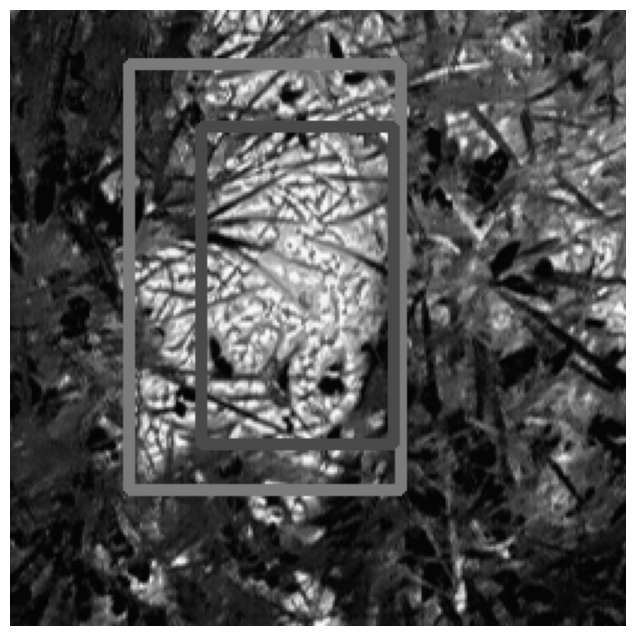

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

    cv2.rectangle(sample,
                  (out_boxes[0][0], out_boxes[0][1]),
                  (out_boxes[0][2], out_boxes[0][3]),
                  (0, 220, 0), 3)

ax.set_axis_off()
ax.imshow(sample, cmap='gray')

In [42]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')